[지원자간의 유사도 8482 X 8482]    
지원자 간 -> 1차 뽑고
[회사간의 유사도 6695 X 6695]

# pip & import

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import category_encoders as ce
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD, NMF, SparsePCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import easydict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# data 불러오기

In [ ]:
apply_train = pd.read_csv('./apply_train.csv')
apply_train = apply_train.sort_values(by='resume_seq')
apply_train

,resume_seq,recruitment_seq
11989,U00001,R05210
342,U00001,R05288
51174,U00001,R04536
28858,U00001,R06065
50591,U00002,R01103
...,...,...
13950,U08481,R00225
22895,U08481,R05500
33843,U08482,R03633
54343,U08482,R03743


사람 -> 회사 최소 2 최대 77  
회사 -> 사람 최소 1 최대 78  
사람 -> 회사 추천 하는게 바람직 (train, test 나누기 힘듦)

# Data 불러오고 합치기

## total

In [ ]:
total = apply_train.copy()

In [ ]:
total_matrix = total.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=1)
total_matrix[total_matrix > 1] = 1

## resume (resume_seq 기준)

In [ ]:
resume_train = apply_train.groupby('resume_seq')['recruitment_seq'].apply(';'.join).reset_index()
resume_train

,resume_seq,recruitment_seq
0,U00001,R05210;R05288;R04536;R06065
1,U00002,R01103;R01730;R06019;R01960;R02946;R02346;R045...
2,U00003,R03301;R04918;R01460
3,U00004,R05367;R04166;R02355;R02003;R02899;R00312;R000...
4,U00005,R00832;R03914;R00374
...,...,...
8477,U08478,R02170;R03939
8478,U08479,R02988;R03837;R01470;R04036;R04196;R02787
8479,U08480,R03152;R00803
8480,U08481,R06253;R00225;R05500


In [ ]:
resume = pd.read_csv('./resume.csv')
resume = resume.sort_values(by='resume_seq')
resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code
1690,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,NaN,0,NaN
3979,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,NaN,73,기타 공공;개인서비스
5648,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,NaN,113,섬유;봉제;가방;의류
1367,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,NaN,27,섬유;봉제;가방;의류
5242,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,NaN,60,섬유;봉제;가방;의류
2227,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,NaN,59,디자인;CAD;설계
2657,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,NaN,0,NaN
6619,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,NaN,8,섬유;봉제;가방;의류


In [ ]:
resume_certificate = pd.read_csv('./resume_certificate.csv')
resume_certificate = resume_certificate.sort_values(by='resume_seq')
resume_certificate

,resume_seq,certificate_contents
6855,U00002,자동차 운전면허 (2종 보통)
6458,U00003,운전면허2종보통
4424,U00003,컬러리스트 기사
7553,U00003,워드프로세서 1급
1509,U00004,정보처리기능사
...,...,...
6980,U08480,컬러리스트기사
7043,U08480,컴퓨터패션디자인운용마스터
335,U08481,컴퓨터활용능력 2급
7386,U08482,컴퓨터그래픽스운용기능사


In [ ]:
resume_certificate = resume_certificate.dropna(subset=['certificate_contents'])
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()
resume_certificate

,resume_seq,certificate_contents
0,U00002,자동차 운전면허 (2종 보통)
1,U00003,운전면허2종보통;컬러리스트 기사;워드프로세서 1급
2,U00004,정보처리기능사;유통관리사 2급;MOS EXCEL 2003 EXPERT
3,U00006,운전면허 1종 보통;문서실무사1급;유통관리사 2급
4,U00007,샵마스터;자동차운전면허1종 보통;패턴 양장 기능사;MICROSOFT OFFICE E...
...,...,...
5971,U08476,운전면허2종보통
5972,U08479,컴퓨터그래픽스운용기능사
5973,U08480,2종 보통 운전면허증;컴퓨터그래픽스운용기능사;컬러리스트기사;컴퓨터패션디자인운용마스터
5974,U08481,컴퓨터활용능력 2급


In [ ]:
resume_education = pd.read_csv('./resume_education.csv')
resume_education = resume_education.sort_values(by='resume_seq')
resume_education

,resume_seq,hischool_type_seq,hischool_special_type,hischool_nation,hischool_gender,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score
5714,U00001,21,일반고,공립,여자학교,4,5,5,0,17,NaN,NaN,9,20.0
3375,U00002,0,기타,기타,기타,0,5,5,0,3,NaN,NaN,8,90.0
201,U00003,21,일반고,공립,남여공학,6,5,5,0,17,NaN,NaN,4,90.0
586,U00004,21,일반고,공립,남여공학,5,5,5,0,5,NaN,NaN,3,70.0
7970,U00005,21,일반고,공립,여자학교,5,0,0,0,0,NaN,NaN,10,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6923,U08478,21,일반고,공립,남여공학,3,5,5,0,5,NaN,NaN,19,0.0
5091,U08479,21,자율고,사립,남여공학,3,3,6,0,3,가정과,NaN,9,0.0
2775,U08480,0,기타,기타,기타,0,5,5,0,10,미술대학섬유패션코디네이션학과,NaN,9,80.0
334,U08481,21,자율고,공립,여자학교,5,5,5,0,5,NaN,NaN,9,60.0


In [ ]:
resume_language = pd.read_csv('./resume_language.csv')
resume_language = resume_language.sort_values(by='resume_seq')
resume_language

,resume_seq,language,exam_name,score
45,U00004,2,11,661.62
701,U00005,2,4,873.74
205,U00039,2,4,848.48
645,U00054,2,4,909.09
769,U00067,2,2,20.00
...,...,...,...,...
424,U08443,4,5,676.77
728,U08461,2,4,676.77
278,U08465,2,11,11.11
212,U08472,2,4,611.11


In [ ]:
resume_language['lang_exam_score'] = resume_language['language'].astype(str) + ';' + resume_language['exam_name'].astype(str) + ';' + resume_language['score'].astype(str)
resume_language = resume_language.drop(['language','exam_name', 'score', 'score'], axis=1)
resume_language

,resume_seq,lang_exam_score
45,U00004,2;11;661.62
701,U00005,2;4;873.74
205,U00039,2;4;848.48
645,U00054,2;4;909.09
769,U00067,2;2;20.0
...,...,...
424,U08443,4;5;676.77
728,U08461,2;4;676.77
278,U08465,2;11;11.11
212,U08472,2;4;611.11


In [ ]:
resume_language = resume_language.dropna(subset=['lang_exam_score'])
resume_language = resume_language.groupby('resume_seq')['lang_exam_score'].apply('&'.join).reset_index()
resume_language

,resume_seq,lang_exam_score
0,U00004,2;11;661.62
1,U00005,2;4;873.74
2,U00039,2;4;848.48
3,U00054,2;4;909.09
4,U00067,2;2;20.0
...,...,...
815,U08443,4;5;676.77
816,U08461,2;4;676.77
817,U08465,2;11;11.11
818,U08472,2;4;611.11


In [ ]:
merged_resume = pd.merge(resume, resume_certificate, on='resume_seq', how='left')
merged_resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code,certificate_contents
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,NaN,0,NaN,NaN
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,NaN,73,기타 공공;개인서비스,자동차 운전면허 (2종 보통)
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,NaN,113,섬유;봉제;가방;의류,운전면허2종보통;컬러리스트 기사;워드프로세서 1급
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,NaN,27,섬유;봉제;가방;의류,정보처리기능사;유통관리사 2급;MOS EXCEL 2003 EXPERT
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,NaN,60,섬유;봉제;가방;의류,NaN
8478,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,NaN,59,디자인;CAD;설계,컴퓨터그래픽스운용기능사
8479,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,NaN,0,NaN,2종 보통 운전면허증;컴퓨터그래픽스운용기능사;컬러리스트기사;컴퓨터패션디자인운용마스터
8480,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,NaN,8,섬유;봉제;가방;의류,컴퓨터활용능력 2급


In [ ]:
merged_resume = pd.merge(merged_resume, resume_education, on='resume_seq', how='left')
merged_resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,...,hischool_gender,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,여자학교,4,5,5,0,17,NaN,NaN,9,20.0
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,...,기타,0,5,5,0,3,NaN,NaN,8,90.0
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,...,남여공학,6,5,5,0,17,NaN,NaN,4,90.0
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,...,남여공학,5,5,5,0,5,NaN,NaN,3,70.0
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,...,여자학교,5,0,0,0,0,NaN,NaN,10,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,...,남여공학,3,5,5,0,5,NaN,NaN,19,0.0
8478,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,...,남여공학,3,3,6,0,3,가정과,NaN,9,0.0
8479,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,...,기타,0,5,5,0,10,미술대학섬유패션코디네이션학과,NaN,9,80.0
8480,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,여자학교,5,5,5,0,5,NaN,NaN,9,60.0


In [ ]:
merged_resume = pd.merge(merged_resume, resume_language, on='resume_seq', how='left')
merged_resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,...,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score,lang_exam_score
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,4,5,5,0,17,NaN,NaN,9,20.0,NaN
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,...,0,5,5,0,3,NaN,NaN,8,90.0,NaN
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,...,6,5,5,0,17,NaN,NaN,4,90.0,NaN
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,...,5,5,5,0,5,NaN,NaN,3,70.0,2;11;661.62
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,...,5,0,0,0,0,NaN,NaN,10,50.0,2;4;873.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,...,3,5,5,0,5,NaN,NaN,19,0.0,NaN
8478,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,...,3,3,6,0,3,가정과,NaN,9,0.0,NaN
8479,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,...,0,5,5,0,10,미술대학섬유패션코디네이션학과,NaN,9,80.0,NaN
8480,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,5,5,5,0,5,NaN,NaN,9,60.0,NaN


In [ ]:
resume_train = pd.merge(resume_train, merged_resume, on='resume_seq', how='left')
resume_train

,resume_seq,recruitment_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,...,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score,lang_exam_score
0,U00001,R05210;R05288;R04536;R06065,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,...,4,5,5,0,17,NaN,NaN,9,20.0,NaN
1,U00002,R01103;R01730;R06019;R01960;R02946;R02346;R045...,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,...,0,5,5,0,3,NaN,NaN,8,90.0,NaN
2,U00003,R03301;R04918;R01460,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,...,6,5,5,0,17,NaN,NaN,4,90.0,NaN
3,U00004,R05367;R04166;R02355;R02003;R02899;R00312;R000...,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,...,5,5,5,0,5,NaN,NaN,3,70.0,2;11;661.62
4,U00005,R00832;R03914;R00374,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,...,5,0,0,0,0,NaN,NaN,10,50.0,2;4;873.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,R02170;R03939,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,...,3,5,5,0,5,NaN,NaN,19,0.0,NaN
8478,U08479,R02988;R03837;R01470;R04036;R04196;R02787,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,...,3,3,6,0,3,가정과,NaN,9,0.0,NaN
8479,U08480,R03152;R00803,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,...,0,5,5,0,10,미술대학섬유패션코디네이션학과,NaN,9,80.0,NaN
8480,U08481,R06253;R00225;R05500,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,...,5,5,5,0,5,NaN,NaN,9,60.0,NaN


idx 대신 resume_seq를 직접 사용

## company (recruitment_seq 기준)

In [ ]:
recruitment_train = apply_train.groupby('recruitment_seq')['resume_seq'].apply(';'.join).reset_index()
recruitment_train

,recruitment_seq,resume_seq
0,R00001,U01670;U03957;U04097;U04364;U04491;U04614;U055...
1,R00002,U00886;U01013;U01875;U02642;U03778;U04822
2,R00003,U03528;U05517;U05808;U06416;U07010;U08000;U08089
3,R00004,U00004;U00164;U00296;U00490;U01421;U01519;U016...
4,R00005,U00695;U01407;U02905;U08049;U08344
...,...,...
6690,R06691,U01236;U03261;U04141;U04861;U05018;U05625
6691,R06692,U00036;U00243;U01206;U03975;U04666;U05870;U065...
6692,R06693,U02092;U03866;U08018;U08281
6693,R06694,U01074;U02793;U04648;U05548;U05762;U06373;U06672


In [ ]:
company = pd.read_csv('./company.csv')
company = company.sort_values(by='recruitment_seq')
company

,recruitment_seq,company_type_seq,supply_kind,employee
1103,R00001,5,201,631
2343,R00002,2,201,160
1986,R00004,2,402,500
352,R00009,2,402,41
1087,R00011,2,100,200
...,...,...,...,...
1439,R06670,5,402,300
1808,R06676,2,402,11
811,R06677,9,402,20
1449,R06688,2,402,90


In [ ]:
recruitment = pd.read_csv('./recruitment.csv')
recruitment = recruitment.sort_values(by='recruitment_seq')
recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword
4573,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN
5915,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN
6454,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN
5905,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN
4197,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5983,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN
2367,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN
6235,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN
3298,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN


company 같은 경우 자료가 2377개 있으니 recruitment에 합쳐지는게 좋음

In [ ]:
merged_recruitment = pd.merge(recruitment, company, on='recruitment_seq', how='left')
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


In [ ]:
merged_recruitment.set_index('recruitment_seq', inplace=True)
merged_recruitment

,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
recruitment_seq,,,,,,,,,,,,,
R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN


In [ ]:
'''merged_recruitment = merged_recruitment.fillna(0) # NaN 값 0으로 대체
merged_recruitment'''

'merged_recruitment = merged_recruitment.fillna(0) # NaN 값 0으로 대체\nmerged_recruitment'

In [ ]:
recruitment_train = pd.merge(recruitment_train, merged_recruitment, on='recruitment_seq', how='left')
recruitment_train

,recruitment_seq,resume_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,U01670;U03957;U04097;U04364;U04491;U04614;U055...,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,U00886;U01013;U01875;U02642;U03778;U04822,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,U03528;U05517;U05808;U06416;U07010;U08000;U08089,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,U00004;U00164;U00296;U00490;U01421;U01519;U016...,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,U00695;U01407;U02905;U08049;U08344,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,U01236;U03261;U04141;U04861;U05018;U05625,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,U00036;U00243;U01206;U03975;U04666;U05870;U065...,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,U02092;U03866;U08018;U08281,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,U01074;U02793;U04648;U05548;U05762;U06373;U06672,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


# resume_train, recruitment_train으로 다 합쳐 놓음

## 각각의 shape, null

In [ ]:
resume_train.shape

(8482, 29)

In [ ]:
recruitment_train.shape

(6695, 15)

In [ ]:
resume_train.isnull().sum()

resume_seq                  0
recruitment_seq             0
reg_date                    0
updated_date                0
degree                      0
graduate_date               0
hope_salary                 0
last_salary                 0
text_keyword              195
job_code_seq1               0
job_code_seq2            7982
job_code_seq3            8295
career_month                0
career_job_code           758
certificate_contents     2506
hischool_type_seq           0
hischool_special_type       0
hischool_nation             0
hischool_gender             0
hischool_location_seq       0
univ_type_seq1              0
univ_type_seq2              0
univ_transfer               0
univ_location               0
univ_major               6687
univ_sub_major           8066
univ_major_type             0
univ_score                  0
lang_exam_score          7662
dtype: int64

job_code_seq3 는 8482명 중에 8295개가 Null이네  
carr_month 경력이 다 있으니 신입 / 경력직 구분 가능하겠다  
대학교 전공을 입력 안한 사람이 많은데 cosine에서 사용하는게 괜찮나?  
text_keyword 직무 키워드를 195명이 안적었는데 이사람들 빼고는 써야겠다.


In [ ]:
recruitment_train.isnull().sum()

recruitment_seq         0
resume_seq              0
address_seq1            1
address_seq2         6595
address_seq3         6686
career_end              0
career_start            0
check_box_keyword       0
education               0
major_task              0
qualifications          0
text_keyword         5988
company_type_seq     4318
supply_kind          4318
employee             4318
dtype: int64

회사 6695 중에 address_seq2, address_seq3가 필요 없을거 같음  
text_keyword는 약 700개 빼고 누락되었는데 직무키워드 사용하기 어려운데 고민  
company에서 가져온 정보 2천개 가량만 입력되어있는데 이건 사용해야함  



## EDA 해보기

In [ ]:
unique_company_types = recruitment_train['company_type_seq'].unique()
num_unique_company_types = len(unique_company_types)
print("총 고유한 'company_type_seq' 개수:", num_unique_company_types)
print("고유한 'company_type_seq':", unique_company_types)

총 고유한 'company_type_seq' 개수: 7
고유한 'company_type_seq': [ 5.  2. nan  4.  9.  3.  7.]


company_type이 2,3,4,5,7,9로 종류가 6개임

<Axes: >

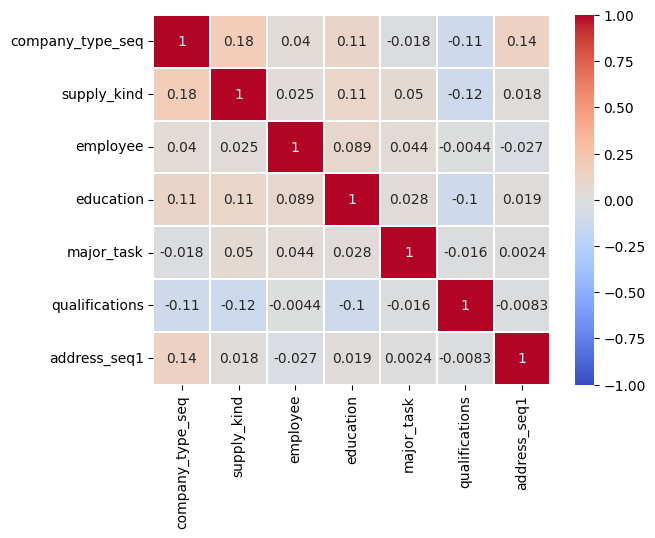

In [ ]:
recruitment_train2 = recruitment_train[['company_type_seq', 'supply_kind', 'employee', 'education', 'major_task', 'qualifications',
                                        'address_seq1']]
recruitment_train3 = recruitment_train2.select_dtypes(include=np.number)
sns.heatmap(recruitment_train3.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

여러개인 경우 ;으로 묶어두고  
언어 같은 경우 & 으로 나눔

# 함수 정의

In [ ]:
def recall5(answer_df, submission_df):

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    #
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    recall = np.mean(individual_recalls)
    return recall

In [ ]:
def minimum_condition(resume, company):
  if(resume['degree'] < company['education']):
    return False
  if(resume['career_month']>company['career_end'] or resume['career_month']<company['career_start']):
    return False

In [ ]:
a=3
b=1

In [ ]:
resume_c = resume.copy()
recruitment_c = recruitment.copy()

In [ ]:
resume_c.set_index('resume_seq', inplace=True)
recruitment_c.set_index('recruitment_seq', inplace=True)

In [ ]:
minimum_condition(resume_c.loc['U00082'], recruitment_c.loc['R00005'])

False

# resume, recruitment 사용할 것들 정의

In [ ]:
resume_train_x = resume_train[['resume_seq', 'text_keyword', 'job_code_seq1', 'univ_major_type']]
resume_train_x

,resume_seq,text_keyword,job_code_seq1,univ_major_type
0,U00001,디자이너,재료·화학·섬유·의복,9
1,U00002,디자이너,재료·화학·섬유·의복,8
2,U00003,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,4
3,U00004,상품기획;영업기획,재료·화학·섬유·의복,3
4,U00005,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,10
...,...,...,...,...
8477,U08478,상품기획,재료·화학·섬유·의복,19
8478,U08479,디자이너,재료·화학·섬유·의복,9
8479,U08480,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,9
8480,U08481,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,9


In [ ]:
resume_train_x.isnull().sum()

resume_seq           0
text_keyword       195
job_code_seq1        0
univ_major_type      0
dtype: int64

In [ ]:
#학습, 검증 분리
train, test = [], []
apply_train_groupby = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        train.append([uid,iid])
    test.append([uid, iids[-1]])

여기서 test는 answer_df 으로 우리가 안에서 맞춰야하는 것이다.

In [ ]:
train = pd.DataFrame(train, columns=['resume_seq', 'recruitment_seq'])
test = pd.DataFrame(test, columns=['resume_seq', 'recruitment_seq'])
pred = apply_train.copy()

In [ ]:
train_train = train.copy()
test_test = test.copy()

In [ ]:
train = train.groupby('resume_seq')['recruitment_seq'].apply(';'.join).reset_index()
pred = pred.groupby('resume_seq')['recruitment_seq'].apply(';'.join).reset_index()

train = train.drop(columns = ['recruitment_seq'])
pred = pred.drop(columns = ['recruitment_seq'])

In [ ]:
train

,resume_seq
0,U00001
1,U00002
2,U00003
3,U00004
4,U00005
...,...
8477,U08478
8478,U08479
8479,U08480
8480,U08481


In [ ]:
'''train2 = resume_train_x[['resume_seq', 'text_keyword']]
pred2 = resume_train_x[['resume_seq', 'text_keyword']]'''

"train2 = resume_train_x[['resume_seq', 'text_keyword']]\npred2 = resume_train_x[['resume_seq', 'text_keyword']]"

In [ ]:
'''train2 = train2.set_index(['resume_seq'])['text_keyword'].str.split(';', expand=True).stack().reset_index().drop('level_1', axis=1)
train2.columns = ['resume_seq', 'text_keyword']
pred2 = pred2.set_index(['resume_seq'])['text_keyword'].str.split(';', expand=True).stack().reset_index().drop('level_1', axis=1)
pred2.columns = ['resume_seq', 'text_keyword']
train2'''

"train2 = train2.set_index(['resume_seq'])['text_keyword'].str.split(';', expand=True).stack().reset_index().drop('level_1', axis=1)\ntrain2.columns = ['resume_seq', 'text_keyword']\npred2 = pred2.set_index(['resume_seq'])['text_keyword'].str.split(';', expand=True).stack().reset_index().drop('level_1', axis=1)\npred2.columns = ['resume_seq', 'text_keyword']\ntrain2"

In [ ]:
'''train2 = train2.groupby(['resume_seq', 'text_keyword']).size().unstack(fill_value=0)
pred2 = pred2.groupby(['resume_seq', 'text_keyword']).size().unstack(fill_value=0)'''

"train2 = train2.groupby(['resume_seq', 'text_keyword']).size().unstack(fill_value=0)\npred2 = pred2.groupby(['resume_seq', 'text_keyword']).size().unstack(fill_value=0)"

In [ ]:
train3 = resume_train_x[['resume_seq', 'job_code_seq1']]
pred3 = resume_train_x[['resume_seq', 'job_code_seq1']]

In [ ]:
train3 = train3.groupby(['resume_seq', 'job_code_seq1']).size().unstack(fill_value=0)
pred3 = pred3.groupby(['resume_seq', 'job_code_seq1']).size().unstack(fill_value=0)

In [ ]:
train4 = resume_train_x[['resume_seq', 'univ_major_type']]
pred4 = resume_train_x[['resume_seq', 'univ_major_type']]

In [ ]:
train4 = train4.groupby(['resume_seq', 'univ_major_type']).size().unstack(fill_value=0)
pred4 = pred4.groupby(['resume_seq', 'univ_major_type']).size().unstack(fill_value=0)

In [ ]:
#train = pd.merge(train, train2, on='resume_seq', how='left')
train = pd.merge(train, train3, on='resume_seq', how='left')
train = pd.merge(train, train4, on='resume_seq', how='left')

#pred = pd.merge(train, pred2, on='resume_seq', how='left')
pred = pd.merge(train, pred3, on='resume_seq', how='left')
pred = pd.merge(train, pred4, on='resume_seq', how='left')

In [ ]:
train

,resume_seq,IT·게임,건설·기계·전기·전자,경영·기획·회계·사무,기타 직종,디자인,문화·예술·신문·방송,영업·판매·TM,재료·화학·섬유·의복,전문·교육·자격,...,14,15,16,17,18,19,20,21,22,23
0,U00001,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,U00002,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,U00003,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,U00004,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,U00005,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8478,U08479,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8479,U08480,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8480,U08481,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.set_index('resume_seq', inplace=True)
pred.set_index('resume_seq', inplace=True)

# 회사

In [ ]:
recruitment_train

,recruitment_seq,resume_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,U01670;U03957;U04097;U04364;U04491;U04614;U055...,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,U00886;U01013;U01875;U02642;U03778;U04822,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,U03528;U05517;U05808;U06416;U07010;U08000;U08089,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,U00004;U00164;U00296;U00490;U01421;U01519;U016...,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,U00695;U01407;U02905;U08049;U08344,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,U01236;U03261;U04141;U04861;U05018;U05625,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,U00036;U00243;U01206;U03975;U04666;U05870;U065...,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,U02092;U03866;U08018;U08281,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,U01074;U02793;U04648;U05548;U05762;U06373;U06672,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


In [ ]:
c_train = recruitment_train[['recruitment_seq']]

In [ ]:
c_train

,recruitment_seq
0,R00001
1,R00002
2,R00003
3,R00004
4,R00005
...,...
6690,R06691
6691,R06692
6692,R06693
6693,R06694


In [ ]:
c_train2 = recruitment_train[['recruitment_seq', 'check_box_keyword']]

In [ ]:
c_train2 = c_train2.set_index(['recruitment_seq'])['check_box_keyword'].str.split(';', expand=True).stack().reset_index().drop('level_1', axis=1)
c_train2.columns = ['recruitment_seq', 'check_box_keyword']
c_train2 = c_train2.groupby(['recruitment_seq', 'check_box_keyword']).size().unstack(fill_value=0)

In [ ]:
c_train3 = recruitment_train[['recruitment_seq', 'address_seq1']]
c_train3 = c_train3.groupby(['recruitment_seq', 'address_seq1']).size().unstack(fill_value=0)

In [ ]:
c_train4 = recruitment_train[['recruitment_seq', 'major_task']]
c_train4 = c_train4.groupby(['recruitment_seq', 'major_task']).size().unstack(fill_value=0)

In [ ]:
c_train5 = recruitment_train[['recruitment_seq', 'text_keyword']]
c_train5 = c_train5.groupby(['recruitment_seq', 'text_keyword']).size().unstack(fill_value=0)

In [ ]:
c_train = pd.merge(c_train, c_train2, on='recruitment_seq', how='left')
c_train = pd.merge(c_train, c_train3, on='recruitment_seq', how='left')
c_train = pd.merge(c_train, c_train4, on='recruitment_seq', how='left')
c_train = pd.merge(c_train, c_train5, on='recruitment_seq', how='left')

In [ ]:
c_train.set_index('recruitment_seq', inplace=True)

# train null 지우기

In [ ]:
train.fillna(0, inplace=True)
pred.fillna(0, inplace=True)
c_train.fillna(0, inplace=True) # 위에서 null값 채우는거 정리 해야함

In [ ]:
apply_user = apply_train.copy()
apply_user = apply_user.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
apply_user[apply_user > 1] = 1

In [ ]:
apply_user

recruitment_seq,R00001,R00002,R00003,R00004,R00005,R00006,R00007,R00008,R00009,R00010,...,R06686,R06687,R06688,R06689,R06690,R06691,R06692,R06693,R06694,R06695
resume_seq,,,,,,,,,,,,,,,,,,,,,
U00001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00004,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U08478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U08479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U08480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
apply_train2 = apply_train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0) # 전체에서 활용할 것
apply_train2.shape

(8482, 6695)

In [ ]:
train_train2 = train_train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0) # train에서 활용할 것
train_train2.shape

(8482, 6690)

In [ ]:
# train_train2 shape를 8482, 6690 -> 8482, 6695로 만들기 위해서 사용
# 전체 데이터셋의 열 목록
total_columns = apply_train2.columns.tolist()

# train 데이터셋에 누락된 열 추가
for col in total_columns:
    if col not in train_train2.columns:
        train_train2[col] = 0

# 열 순서 정렬
train_train2 = train_train2[total_columns]

# 전체 유사도 계산

In [ ]:
apply_train_similarity = cosine_similarity(train_train2)
apply_pred_similarity = cosine_similarity(apply_user)

In [ ]:
train_user_similarity = cosine_similarity(train) # train 유저 유사도
pred_user_similarity = cosine_similarity(pred) # 전체 data 유저 유사도
train_c_similarity = cosine_similarity(c_train) # 회사 유사도(train을 굳이 나누지 않음)

In [ ]:
total_train_user = a*apply_train_similarity + b*train_user_similarity
total_train_user

array([[4. , 0.5, 0.5, ..., 0.5, 1. , 1. ],
       [0.5, 4. , 0.5, ..., 0. , 0.5, 0.5],
       [0.5, 0.5, 4. , ..., 0. , 0.5, 0.5],
       ...,
       [0.5, 0. , 0. , ..., 4. , 0.5, 0.5],
       [1. , 0.5, 0.5, ..., 0.5, 4. , 1. ],
       [1. , 0.5, 0.5, ..., 0.5, 1. , 4. ]])

In [ ]:
total_user = a*apply_pred_similarity + b*pred_user_similarity
total_user

array([[4.        , 0.33333333, 0.33333333, ..., 0.66666667, 1.        ,
        1.        ],
       [0.33333333, 4.        , 0.33333333, ..., 0.        , 0.33333333,
        0.33333333],
       [0.33333333, 0.33333333, 4.        , ..., 0.        , 0.33333333,
        0.33333333],
       ...,
       [0.66666667, 0.        , 0.        , ..., 4.        , 0.66666667,
        0.66666667],
       [1.        , 0.33333333, 0.33333333, ..., 0.66666667, 4.        ,
        1.        ],
       [1.        , 0.33333333, 0.33333333, ..., 0.66666667, 1.        ,
        4.        ]])

# 정답 도출

In [ ]:
# DataFrame 생성
total_train_user_matrix = pd.DataFrame(total_train_user)

# 행과 열 이름 설정
total_train_user_matrix.columns = [f'U{i:05d}' for i in range(1, 8483)]
total_train_user_matrix.index = [f'U{i:05d}' for i in range(1, 8483)]

# 결과 확인
total_train_user_matrix.head()

,U00001,U00002,U00003,U00004,U00005,U00006,U00007,U00008,U00009,U00010,...,U08473,U08474,U08475,U08476,U08477,U08478,U08479,U08480,U08481,U08482
U00001,4.0,0.5,0.5,0.5,0.5,0.5,0.5,0.500000,0.0,0.5,...,0.5,1.0,0.5,0.5,0.5,0.5,1.0,0.5,1.0,1.0
U00002,0.5,4.0,0.5,0.5,0.5,0.5,0.5,0.500000,0.0,0.5,...,0.5,0.5,0.5,1.0,0.5,0.5,0.5,0.0,0.5,0.5
U00003,0.5,0.5,4.0,0.5,0.5,0.5,0.5,0.500000,0.0,0.5,...,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.0,0.5,0.5
U00004,0.5,0.5,0.5,4.0,0.5,0.5,0.5,0.753546,0.0,1.0,...,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5
U00005,0.5,0.5,0.5,0.5,4.0,0.5,0.5,0.500000,0.0,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,0.5


In [ ]:
recommendations = []

for idx, user in enumerate(total_train_user_matrix.index):
    # 해당 사용자가 지원한 채용 공고
    applied_jobs = set(train_train[train_train['resume_seq'] == user]['recruitment_seq'].values)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_user_indices = total_train_user[idx].argsort()[::-1]
    for idxx, sor in enumerate(sorted_user_indices):
      sor = f'U{str(sor+1).zfill(5)}'
      recommended_jobs = [job for job in train_train2.loc[sor][train_train2.loc[sor] == 1].index
                          if (job not in applied_jobs) and (minimum_condition(resume_c.loc[user], recruitment_c.loc[job]))][:5]

    for job in recommended_jobs:
        recommendations.append([user, job])
        print(recommendations[-1])

KeyboardInterrupt: ignored

In [ ]:
val_prediction = pd.DataFrame(recommendations, columns=['resume_seq', 'recruitment_seq'])

In [ ]:
recall5(test,val_prediction)

0.0008252770572978071

In [ ]:
pre_recommendations = []
for idx, user in enumerate(apply_train2.index):
    # 해당 사용자가 지원한 채용 공고
    applied_jobs = set(apply_train2.loc[user][apply_train2.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = total_user[idx].argsort()[::-1]
    for idxx, sor in enumerate(sorted_user_indices):
      sor = f'U{str(sor+1).zfill(5)}'
    recommended_jobs = [job for job in apply_train2.columns[sor][apply_train2.loc[sor]==1].index
                        if job not in applied_jobs and minimum_condition(resume_c.loc[user], recruitment_c.loc[job])][:5]

    for job in recommended_jobs:
        pre_recommendations.append([user, job])

In [ ]:
    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_user_indices = total_train_user[idx].argsort()[::-1]
    for idxx, sor in enumerate(sorted_user_indices):
      sor = f'U{str(sor+1).zfill(5)}'
      recommended_jobs = [job for job in train_train2.loc[sor][train_train2.loc[sor] == 1].index
                          if job not in applied_jobs and minimum_condition(resume_c.loc[user], recruitment_c.loc[job])][:5]

In [ ]:
top_recommendations = pd.DataFrame(pre_recommendations, columns=['resume_seq', 'recruitment_seq'])
top_recommendations.to_csv('./H_submission.csv', index=False)